## Inspecting the data of Jena weather dataset

In [1]:
import os

data_dir = "/home/mir/Dataset"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


## Parsing data

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    
    values = [float(x) for x in line.split(',')[1:]]  
    float_data[i, :] = values 

## Plotting the temperature time series

In [3]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

## Plotting the first 10 days of the temperature time series

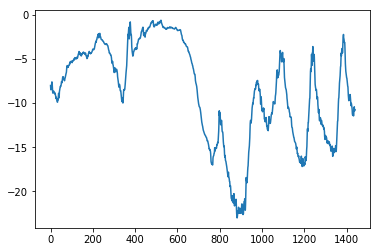

In [4]:
plt.plot(range(1440), temp[:1440])

## Normalizing the data

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

## Generator yielding time series samples and their targets

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False,
              batch_size=128, step=6):
    
    """
    Lookback: timesteps to go back
    delay: future targets
    min_index,max_index: timesteps to draw from
    steps = timesteps at which you sample data
    """
    
    if max_index is None:
        
        max_index = len(data) - delay - 1
        
    i = min_index + lookback 
        
    while 1:
        
        if shuffle:
            
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
            
        else:
            
            if i + batch_size >= max_index:
                
                i = min_index + lookback
                
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
                
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

## Preparing the training, validation and test generators

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     step=step,
                     batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

val_steps

98559

## Computing the common-sense baseline MAE

In [8]:
def evaluate_naive_method():
    
    batch_maes = []
    for step in range(val_steps):
        
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(targets, preds))
        batch_maes.append(mae)
        
    print(np.mean(batch_maes))
    
#evaluate_naive_method()

## Converting MAE back to Celsius error

In [9]:
#celsius_mae = 0.29 * std[1]

## Training and evaluating a densely connected model

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.summary()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20,
                              validation_data=val_gen, validation_steps=val_steps, verbose=1)

Epoch 1/20
500/500 [==============================] - 790s 2s/step - loss: 0.8505 - val_loss: 0.3082
Epoch 2/20
500/500 [==============================] - 745s 1s/step - loss: 0.3035 - val_loss: 0.3022
Epoch 3/20
500/500 [==============================] - 811s 2s/step - loss: 0.2704 - val_loss: 0.3027
Epoch 4/20
500/500 [==============================] - 790s 2s/step - loss: 0.2561 - val_loss: 0.3044
Epoch 5/20
500/500 [==============================] - 794s 2s/step - loss: 0.2474 - val_loss: 0.3043
Epoch 6/20
495/500 [============================>.] - ETA: 0s - loss: 0.2405